<a href="https://colab.research.google.com/github/ParmveerN/Heart-health-analysis/blob/master/Statistic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports


In [ ]:
import pandas as pd
import math as ma
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/drive/My Drive/data-science/heart-disease-project/heart.csv')

#Data checking

In [ ]:
df.corr()
#checking all correlation between all variables

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


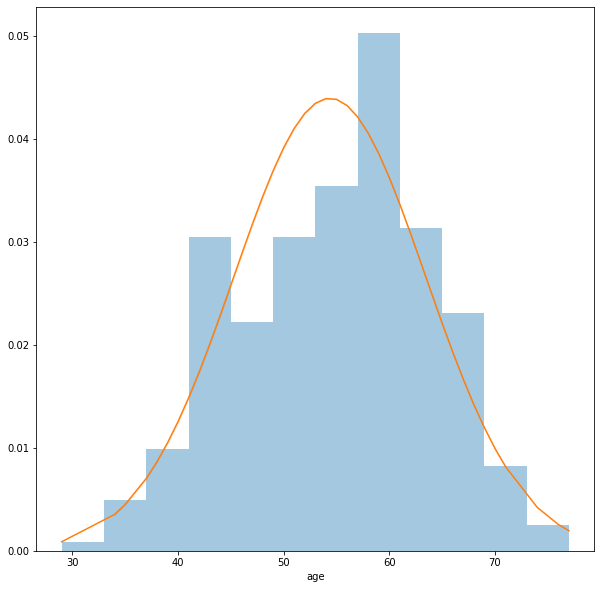

In [ ]:
plt.figure(figsize=(10, 10))

sns.distplot(df['age'], kde=False, norm_hist=True)
pdf_params = sp.stats.norm.fit(df['age'])
age_norm_pdf = sp.stats.norm.pdf(df['age'], *pdf_params)
#checking age distrubtion correlation to norm
sns.lineplot(df['age'], age_norm_pdf)

plt.show()

In [ ]:
dfX = df.drop('target', axis=1)
dfY = df['target']
#making data set for training and testing

#Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size=0.20, random_state=30)
#sizing the data set

In [ ]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

X_train (242, 13)
X_test (61, 13)
y_train (242,)
y_test (61,)


In [ ]:
X_train = ((X_train-np.min(X_train))/(np.max(X_train)- np.min(X_train))).values

X_test = ((X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test))).values
#normalizing the data

In [ ]:
pca = PCA().fit(X_train)
cummulative_sum = np.cumsum(pca.explained_variance_ratio_)
np.where((cummulative_sum < 0.96) & (cummulative_sum > 0.94))[0][0] + 1
#found the pca and the variance ratio to find the where the two values are at its highest peek

8

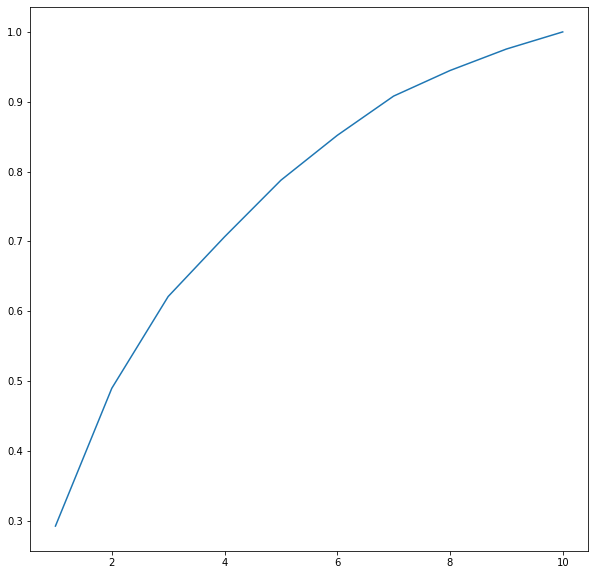

In [ ]:
plt.figure(figsize=(10, 10))
sns.lineplot(x=np.linspace(1, len(cummulative_sum), len(cummulative_sum)), y=cummulative_sum)
plt.show()
#used a graph to visually look at best cummulative sum

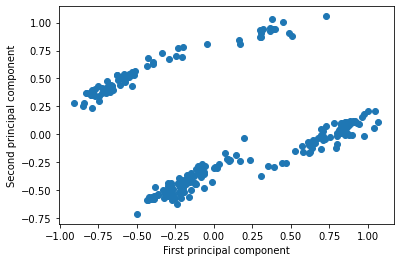

In [ ]:
pca = PCA(n_components=10)
pca.fit(X_train)
reduced_df_train = pca.transform(X_train)
plt.scatter(reduced_df_train[:,0], reduced_df_train[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()
#transforming the data to be reduced so it is easier to test on while using x_train

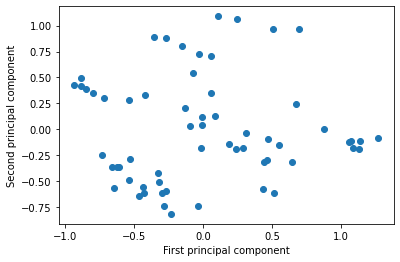

In [ ]:
pca = PCA(n_components=10)
pca.fit(X_test)
reduced_df_test = pca.transform(X_test)
plt.scatter(reduced_df_test[:,0], reduced_df_test[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()
#same thing as before transforming the data to reduced test data for training

In [ ]:
reduced_df_train = pd.DataFrame(reduced_df_train, columns=['Dim1', 'Dim2', 'Dim3', 'Dim4','Dim5','Dim6','Dim7','Dim8','Dim9','Dim10'])
reduced_df_test = pd.DataFrame(reduced_df_test, columns=['Dim1', 'Dim2', 'Dim3', 'Dim4','Dim5','Dim6','Dim7','Dim8','Dim9','Dim10'])
X_train = reduced_df_train
X_test = reduced_df_test
#using the reduced data i made my own 10 columes 

In [ ]:
#setting up plotting function for roc_curve of logistic regression which will be done later
def plot_roc_(flase_positive_rate, true_positive_rate, roc_auc):
  plt.figure(figsize=(5,5))
  plt.title('Reciever operating charateristic')
  plt.plot(flase_positive_rate, true_positive_rate, color='red', label='AUC = %0.2f'% roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1],[0,1], linestyle='--')
  plt.axis('tight')
  plt.ylabel('True positive rate')
  plt.xlabel('false positive rate')
  plt.show()
def plot_feature_importances(gbm):
  n_features = X_train.shape[1]
  plt.brah(range(n_features), gbm.features_importances_, align='center')
  plt.yticks(np.arange(n_features), X_train.columns)
  plt.xlabel("Features importance")
  plt.ylabel("Features")
  plt.ylim(-1, n_features)

In [ ]:
#besting the best pair for logistic regression for penalty, C and random state
parameters = [
{
    'penalty':['l1','l2'],
    'C':[0.1,0.4,0.5, 10, 50, 100],
    'random_state':[0]
    },
]

gslog = GridSearchCV(LogisticRegression(), parameters, scoring='accuracy')
gslog.fit(X_train, y_train)
print('Best parameters set')
print(gslog.best_params_)
print()


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_se

Best parameters set
{'C': 0.4, 'penalty': 'l2', 'random_state': 0}



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


In [ ]:
#using the data retreavied from aboce we are fitting the data 
lr = LogisticRegression(C= gslog.best_params_["C"], penalty= gslog.best_params_["penalty"], random_state= gslog.best_params_["random_state"])

lr.fit(X_train, y_train)


LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#finding the prediction and probablity of x_test
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)


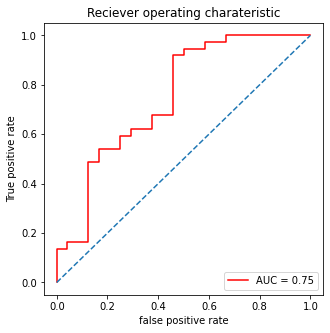

In [ ]:
##plotting the roc curve using the function from above and finding the false and true rates
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba[:,1])
rocC = auc(false_positive_rate, true_positive_rate)
plot_roc_(false_positive_rate, true_positive_rate, rocC)

In [ ]:
#set up confusion matrix for better understanding the vectors
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[15  9]
 [12 25]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.62      0.59        24
           1       0.74      0.68      0.70        37

    accuracy                           0.66        61
   macro avg       0.65      0.65      0.65        61
weighted avg       0.66      0.66      0.66        61



In [ ]:
print(lr.coef_)
print("")
print(lr.intercept_)
print("")
print(lr.predict_log_proba)

[[-2.52562359 -0.35799223 -0.22847988 -1.61938799  0.53296351 -0.21530303
  -0.87682299  0.50310785  0.01106115 -0.09757243]]

[0.11585538]

<bound method LogisticRegression.predict_log_proba of LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>


#Kmeans

In [ ]:
#finsing the parameters for kmean testing
parameters=[
    {
        'n_neighbors': np.arange(1,33),
        'n_jobs':[2,6]
    },
]
gskmean = GridSearchCV(KNeighborsClassifier(), parameters, scoring = 'accuracy')
gskmean.fit(X_train, y_train)
print('Best paramets set')
print(gskmean.best_params_)
print()

Best paramets set
{'n_jobs': 2, 'n_neighbors': 9}



In [ ]:
#using the kmean parameters found above finding the classifier
knn = KNeighborsClassifier(n_neighbors=gskmean.best_params_["n_neighbors"], n_jobs=gskmean.best_params_["n_jobs"])
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=2, n_neighbors=9, p=2,
                     weights='uniform')

In [ ]:
#finding the x_test kmean prediction and probablity
kn_y_pred = knn.predict(X_test)
kn_y_proba = knn.predict_proba(X_test)

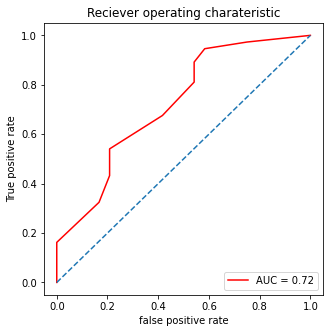

In [ ]:
kn_false_positive_rate, kn_true_positive_rate, kn_thresholds = roc_curve(y_test, kn_y_proba[:,1])
kn_rocC = auc(kn_false_positive_rate, kn_true_positive_rate)
plot_roc_(kn_false_positive_rate, kn_true_positive_rate, kn_rocC)

In [ ]:
kn_cm = confusion_matrix(y_test, kn_y_pred)

In [ ]:
print(classification_report(y_test, kn_y_pred))

              precision    recall  f1-score   support

           0       0.54      0.58      0.56        24
           1       0.71      0.68      0.69        37

    accuracy                           0.64        61
   macro avg       0.63      0.63      0.63        61
weighted avg       0.65      0.64      0.64        61



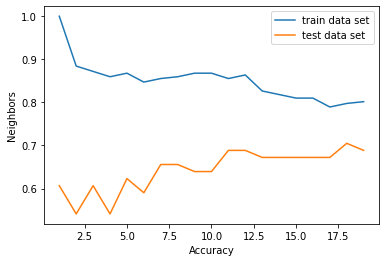

In [ ]:
n_neighbors = range(1,20)
train_data_accuracy = []
test_data_accuracy = []
for n_neigh in n_neighbors:
  knn = KNeighborsClassifier(n_neighbors=n_neigh, n_jobs=gskmean.best_params_["n_jobs"])
  knn.fit(X_train, y_train)
  train_data_accuracy.append(knn.score(X_train, y_train))
  test_data_accuracy.append(knn.score(X_test, y_test))
plt.plot(n_neighbors, train_data_accuracy, label= "train data set")
plt.plot(n_neighbors, test_data_accuracy, label="test data set")
plt.xlabel("Accuracy")
plt.ylabel("Neighbors")
plt.legend()
plt.show()

In [ ]:
n_neighbors = range(1,20)
k_score = []
for n_neigh in n_neighbors:
  knn = KNeighborsClassifier(n_neighbors=n_neigh, n_jobs=gskmean.best_params_["n_jobs"])
  scores = cross_val_score(estimator=knn, X=X_train, y= y_train, cv=12)
  k_score.append(scores.mean())
print(k_score)

[0.7563492063492063, 0.7113095238095237, 0.7978174603174604, 0.7813492063492063, 0.7934523809523809, 0.8097222222222223, 0.817857142857143, 0.826190476190476, 0.8180555555555555, 0.8057539682539682, 0.7847222222222223, 0.7890873015873017, 0.7932539682539682, 0.7851190476190476, 0.7767857142857143, 0.7809523809523808, 0.7726190476190474, 0.7849206349206348, 0.7803571428571429]
